In [4]:
!pip install torch torchvision torchaudio
!pip install transformers datasets scikit-learn seaborn matplotlib gensim
!pip install seqeval torch matplotlib numpy pandas
!pip install -U sentence-transformers
!pip install -U accelerate



In [5]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import gensim.downloader as api  # for loading pre-trained Word2Vec
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset    
from torch.optim import Adam
import torch.nn.functional as F
from collections import Counter 



ModuleNotFoundError: No module named 'numpy'

In [26]:
from datasets import load_dataset
plod_dataset = load_dataset("surrey-nlp/PLOD-CW-25")
print(plod_dataset)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})


In [11]:
data_train=plod_dataset['train']
data_validation=plod_dataset['validation']
data_test=plod_dataset['test']

In [12]:
## Preprocessing

from collections import Counter

# NER Tags mapping (safe way)
if hasattr(plod_dataset["train"].features["ner_tags"], "feature") and hasattr(plod_dataset["train"].features["ner_tags"].feature, "names"):
    ner_tag_names = plod_dataset["train"].features["ner_tags"].feature.names
else:
    # Manual fallback: put your actual label names here if available
    ner_tag_names = ['O', 'B-AC', 'B-LF', 'I-LF']

LABEL_TO_ID = {label: i for i, label in enumerate(ner_tag_names)}
ID_TO_LABEL = {i: label for label, i in LABEL_TO_ID.items()}

# Token Vocabulary
all_tokens = [token for split in plod_dataset for ex in plod_dataset[split] for token in ex["tokens"]]
token_counts = Counter(all_tokens)
TOKEN_VOCAB = {token: i+2 for i, (token, _) in enumerate(token_counts.most_common())}
TOKEN_VOCAB["<PAD>"] = 0
TOKEN_VOCAB["<UNK>"] = 1
ID_TO_TOKEN = {i: token for token, i in TOKEN_VOCAB.items()}

# POS Vocabulary
all_pos_tags = [tag for split in plod_dataset for ex in plod_dataset[split] for tag in ex["pos_tags"]]
pos_tag_counts = Counter(all_pos_tags)
POS_VOCAB = {tag: i+1 for i, (tag, _) in enumerate(pos_tag_counts.most_common())}
POS_VOCAB["<PAD>"] = 0
ID_TO_POS = {i: tag for tag, i in POS_VOCAB.items()}

print("Preprocessing done")

Preprocessing done


In [13]:
# Labels encoders
label_encoding = {"O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

label_list = []
for sample in data_train["ner_tags"]:
    label_list.append([label_encoding[tag] for tag in sample])

val_label_list = []
for sample in data_validation["ner_tags"]:
    val_label_list.append([label_encoding[tag] for tag in sample])

test_label_list = []
for sample in data_test["ner_tags"]:
    test_label_list.append([label_encoding[tag] for tag in sample])


In [3]:
#Importing Word2vec Model
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')


ModuleNotFoundError: No module named 'gensim'

In [ ]:
# Custom Dataset Class
class PlodTokenDataset(Dataset):
    def __init__(self, tokens, labels, model):
        self.tokens = tokens
        self.labels = labels
        self.model = model

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        words = self.tokens[idx]
        embeddings = [self.model[word] if word in self.model else np.zeros(300) for word in words]
        embeddings_tensor = torch.tensor(embeddings, dtype=torch.float)
        labels_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return {"tokens": embeddings_tensor, "labels": labels_tensor}


# Custom collate_fn
def collate_fn(batch):
    # Padded token sequences
    tokens_list = [item["tokens"] for item in batch]
    labels_list = [item["labels"] for item in batch]

    # Pad token sequences to ensure all sequences are the same length
    padded_tokens = nn.utils.rnn.pad_sequence(tokens_list, batch_first=True, padding_value=0)

    # Pad labels
    padded_labels = nn.utils.rnn.pad_sequence(labels_list, batch_first=True, padding_value=-1)

    return {"tokens": padded_tokens.to(DEVICE), "labels": padded_labels.to(DEVICE)}


In [ ]:
# Training Data
bilstm_dataset =  PlodTokenDataset(data_train['tokens'], label_list, word2vec_model)
bilstm_dataloader = DataLoader(bilstm_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)


In [ ]:
# Testing Data
bilstm_dataset_test = PlodTokenDataset(data_test['tokens'], test_label_list, word2vec_model)
bilstm_dataloader_test = DataLoader(bilstm_dataset_test, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [ ]:
#BiLSTM model
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        tag_space = self.fc(lstm_out)
        tag_scores = torch.log_softmax(tag_space, dim=-1)
        return tag_scores

In [ ]:
bilstm_model=BiLSTM(embedding_dim=300,hidden_dim=150,tagset_size=4)

In [ ]:
import numpy as np

optimizer = optim.Adam(bilstm_model.parameters(),lr=0.001)
loss_function = nn.NLLLoss(ignore_index=-1)  # Ignoring padding index (-1) in the loss calculation

# Training loop
for epoch in range(10):
    bilstm_model.train()
    for batch in bilstm_dataloader: # iterate over batches in bilstm_dataloader
        optimizer.zero_grad()
        # Get inputs (tokens) and labels from the current batch
        inputs = batch["tokens"] # access the "tokens" key from the batch dictionary
        labels = batch["labels"] # access the "labels" key from the batch dictionary

        outputs = bilstm_model(inputs)

        loss = loss_function(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
        loss.backward()
        optimizer.step() # calling the function optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.7300896048545837
Epoch 2, Loss: 0.5844814777374268
Epoch 3, Loss: 0.6060922741889954
Epoch 4, Loss: 0.5031229257583618
Epoch 5, Loss: 0.47756198048591614
Epoch 6, Loss: 0.40762951970100403
Epoch 7, Loss: 0.4948630630970001
Epoch 8, Loss: 0.42267197370529175
Epoch 9, Loss: 0.3137311041355133
Epoch 10, Loss: 0.3693501055240631


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# For Word2Vec model predictions
accuracy_w2v = accuracy_score(filtered_labels, filtered_preds)
precision_w2v, recall_w2v, f1_w2v, _ = precision_recall_fscore_support(
    filtered_labels, filtered_preds, average='macro')

print("Word2Vec Model Performance:")
print(f"Accuracy: {accuracy_w2v:.4f}")
print(f"Precision: {precision_w2v:.4f}")
print(f"Recall: {recall_w2v:.4f}")
print(f"F1-Score: {f1_w2v:.4f}")
print()

Word2Vec Model Performance:
Accuracy: 0.8989
Precision: 0.8164
Recall: 0.7998
F1-Score: 0.8077



In [ ]:
# Testing and evaluation
bilstm_model.eval()
bilstm_preds = []
bilstm_labels = []
with torch.no_grad():
    for batch in test_dataloader_bilstm: # Changed to iterate over batches
        inputs = batch["tokens"]  # Accessing tokens from the batch dictionary
        labels = batch["labels"]  # Accessing labels from the batch dictionary
        outputs = bilstm_model(inputs)
        _, predicted = torch.max(outputs, -1)
        bilstm_preds.extend(predicted.view(-1).tolist())
        bilstm_labels.extend(labels.view(-1).tolist())

# Filtering out padded
filtered_preds = [p for p, l in zip(bilstm_preds, bilstm_labels) if l != -1]
filtered_labels = [l for l in bilstm_labels if l != -1]

print(classification_report(filtered_labels, filtered_preds))
print(confusion_matrix(filtered_labels, filtered_preds))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      7751
           1       0.82      0.58      0.68       797
           2       0.69      0.45      0.54       482
           3       0.70      0.60      0.64      1227

    accuracy                           0.85     10257
   macro avg       0.77      0.64      0.70     10257
weighted avg       0.85      0.85      0.85     10257

[[7355   82   73  241]
 [ 314  466    5   12]
 [ 198   10  215   59]
 [ 468    9   18  732]]


In [ ]:
bilstm_cm=calculateConfusionMatrix(filtered_labels, filtered_preds)

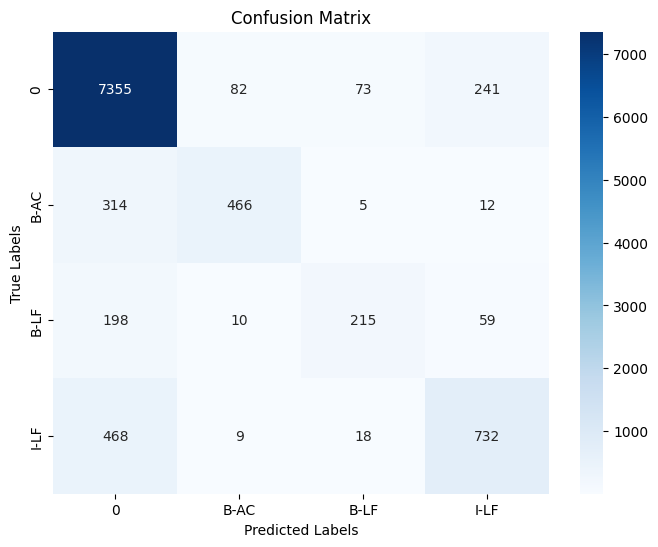

In [ ]:
PlotConfusionMatrix(bilstm_cm)

In [ ]:
text_tokens = ["The", "patient", "was", "diagnosed", "with", "acute", "myeloid", "leukemia", "(", "AML", ")", "."]


In [ ]:
# Prepare embedding vector for the tokens
embeddings = [word2vec_model[word] if word in word2vec_model else np.zeros(300) for word in text_tokens]

# Convert to tensor
input_tensor = torch.tensor([embeddings], dtype=torch.float).to(DEVICE)  # [1, seq_len, 300]

# Set model to eval
bilstm_model.eval()

# Predict
with torch.no_grad():
    outputs = bilstm_model(input_tensor)  # shape: [1, seq_len, tagset_size]
    predicted_tags = torch.argmax(outputs, dim=-1).squeeze(0).tolist()  # remove batch dim


In [ ]:
# ID_TO_LABEL from your earlier steps
predicted_labels = [ID_TO_LABEL[tag_id] for tag_id in predicted_tags]

# Show result
for token, label in zip(text_tokens, predicted_labels):
    print(f"{token:15s} --> {label}")


The             --> O
patient         --> O
was             --> O
diagnosed       --> O
with            --> O
acute           --> B-LF
myeloid         --> I-LF
leukemia        --> I-LF
(               --> O
AML             --> B-AC
)               --> O
.               --> O


Glove

In [ ]:
import gensim.downloader as api
glove_model = api.load('glove-wiki-gigaword-300')

In [ ]:
G_dataset = AbbreviationDataset(data_train['tokens'], label_list, glove_model)
G_dataloader = DataLoader(G_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [ ]:
G_test_dataset = AbbreviationDataset(data_test['tokens'], test_label_list, glove_model)
G_test_dataloader = DataLoader(G_test_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [ ]:
bilstm_glove_model = BiLSTM(embedding_dim=300, hidden_dim=150, tagset_size=4)


In [ ]:
import torch.optim as optim
import torch.nn as nn

optimizer = optim.Adam(bilstm_glove_model.parameters(), lr=0.001)
loss_function = nn.NLLLoss(ignore_index=-1)  # Ignore padding index


for epoch in range(10):
    bilstm_glove_model.train()
    for batch in G_dataloader:
        optimizer.zero_grad()
        inputs = batch["tokens"]
        labels = batch["labels"]

        outputs = bilstm_glove_model(inputs)
        loss = loss_function(outputs.view(-1, outputs.shape[-1]), labels.view(-1))

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.1299743354320526
Epoch 2, Loss: 0.22512228786945343
Epoch 3, Loss: 0.45885324478149414
Epoch 4, Loss: 0.13083423674106598
Epoch 5, Loss: 0.18454843759536743
Epoch 6, Loss: 0.15115772187709808
Epoch 7, Loss: 0.11582496762275696
Epoch 8, Loss: 0.1733078956604004
Epoch 9, Loss: 0.08808708935976028
Epoch 10, Loss: 0.13620008528232574


In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch["tokens"]
            labels = batch["labels"]

            outputs = model(inputs)
            _, predicted = torch.max(outputs, -1)

            # Flatten the predictions and true labels
            predicted = predicted.view(-1)
            labels = labels.view(-1)

            # Filter out padding labels
            valid_indices = labels != -1
            valid_labels = labels[valid_indices]
            valid_predicted = predicted[valid_indices]

            all_preds.extend(valid_predicted.tolist())
            all_labels.extend(valid_labels.tolist())

    return all_preds, all_labels


In [ ]:
 #For GloVe model predictions
accuracy_glove = accuracy_score(filtered_labels, filtered_preds)
precision_glove, recall_glove, f1_glove, _ = precision_recall_fscore_support(
    filtered_labels, filtered_preds, average='macro')

print("GloVe Model Performance:")
print(f"Accuracy: {accuracy_glove:.4f}")
print(f"Precision: {precision_glove:.4f}")
print(f"Recall: {recall_glove:.4f}")
print(f"F1-Score: {f1_glove:.4f}")


GloVe Model Performance:
Accuracy: 0.8548
Precision: 0.7742
Recall: 0.6441
F1-Score: 0.6962


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

bilstm_glove_model.eval()
glove_preds = []
glove_labels = []

with torch.no_grad():
    for batch in G_test_dataloader:
        inputs = batch["tokens"]
        labels = batch["labels"]

        outputs = bilstm_glove_model(inputs)
        _, predicted = torch.max(outputs, -1)

        glove_preds.extend(predicted.view(-1).tolist())
        glove_labels.extend(labels.view(-1).tolist())

# Remove padding labels
filtered_preds = [p for p, l in zip(glove_preds, glove_labels) if l != -1]
filtered_labels = [l for l in glove_labels if l != -1]

print(classification_report(filtered_labels, filtered_preds))
print(confusion_matrix(filtered_labels, filtered_preds))


              precision    recall  f1-score   support

           0       0.93      0.94      0.93      7751
           1       0.76      0.77      0.77       797
           2       0.75      0.70      0.72       482
           3       0.79      0.75      0.77      1227

    accuracy                           0.89     10257
   macro avg       0.81      0.79      0.80     10257
weighted avg       0.89      0.89      0.89     10257

[[7284  174   92  201]
 [ 176  613    3    5]
 [ 107    4  337   34]
 [ 276   13   17  921]]


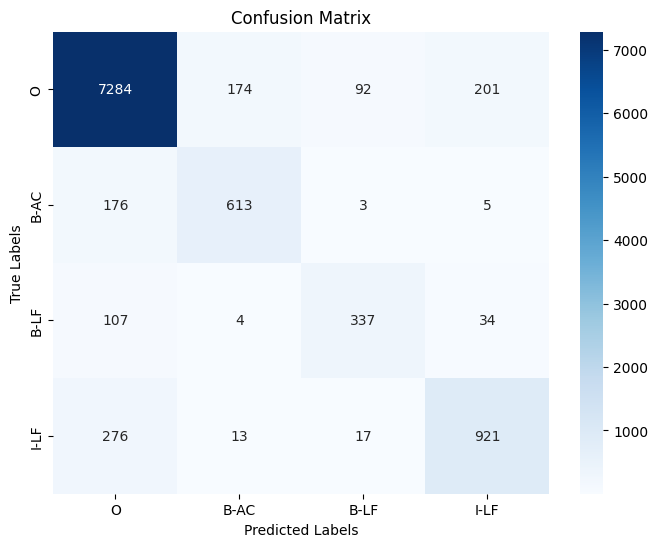

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm):
    labels = ['O', 'B-AC', 'B-LF', 'I-LF']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

cm = confusion_matrix(filtered_labels, filtered_preds)
plot_confusion_matrix(cm)


In [ ]:
text_tokens = ["The", "patient", "was", "diagnosed", "with", "acute", "myeloid", "leukemia", "(", "AML", ")", "."]

# Prepare embedding vector for the tokens
embeddings = [glove_model[word] if word in glove_model else np.zeros(300) for word in text_tokens]

# Convert to tensor
input_tensor = torch.tensor([embeddings], dtype=torch.float).to(DEVICE)  # [1, seq_len, 300]

# Set model to eval
bilstm_glove_model.eval()

# Predict
with torch.no_grad():
    outputs = bilstm_glove_model(input_tensor)  # shape: [1, seq_len, tagset_size]
    predicted_tags = torch.argmax(outputs, dim=-1).squeeze(0).tolist()  # remove batch dim

# ID_TO_LABEL from your earlier steps (adjust as needed)
ID_TO_LABEL = {0: "O", 1: "B-AC", 2: "B-LF", 3: "I-LF"}

predicted_labels = [ID_TO_LABEL[tag_id] for tag_id in predicted_tags]

# Show result
for token, label in zip(text_tokens, predicted_labels):
    print(f"{token:15s} --> {label}")


The             --> O
patient         --> O
was             --> O
diagnosed       --> O
with            --> O
acute           --> B-LF
myeloid         --> I-LF
leukemia        --> I-LF
(               --> O
AML             --> B-AC
)               --> O
.               --> O


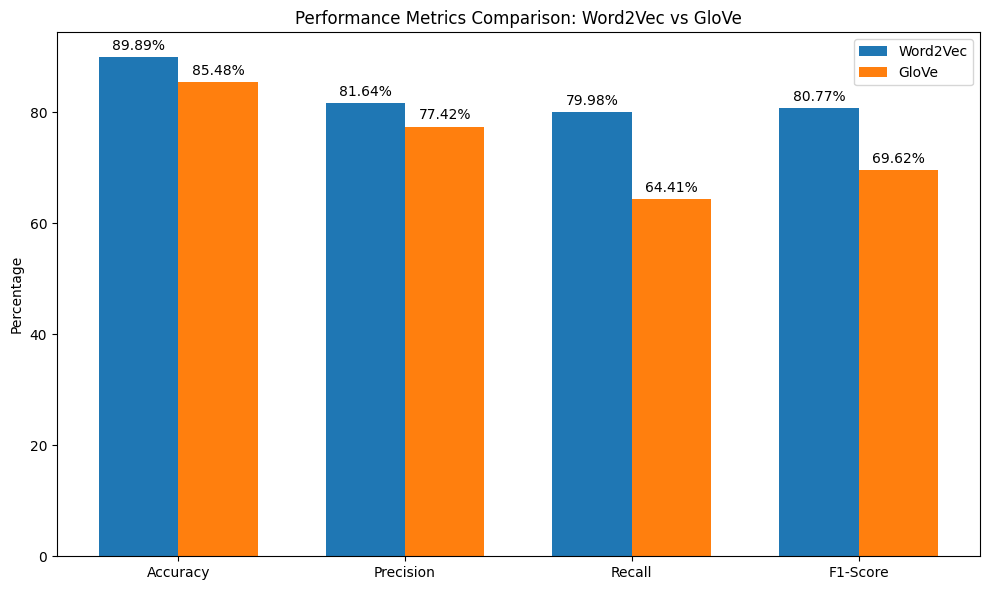

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Models and metrics labels
models = ['Word2Vec', 'GloVe']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Metrics values from your calculations
values_word2vec = [accuracy_w2v * 100, precision_w2v * 100, recall_w2v * 100, f1_w2v * 100]
values_glove = [accuracy_glove * 100, precision_glove * 100, recall_glove * 100, f1_glove * 100]

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, values_word2vec, width, label='Word2Vec')
rects2 = ax.bar(x + width/2, values_glove, width, label='GloVe')

# Add labels, title, and ticks
ax.set_ylabel('Percentage')
ax.set_title('Performance Metrics Comparison: Word2Vec vs GloVe')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add data labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()
